# PPG Peak Detection without Ground‑Truth Labels

https://iopscience.iop.org/article/10.1088/1361-6579/adb89e

In [11]:
import sys
import glob
import re
import os
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader,random_split
from torchinfo import summary

from heart_rhythm_analysis.model.unet1d import UNet1D
from heart_rhythm_analysis.utils.utils import PPGWindow,pseudo_peak_vector,scale_signal,find_sliding_window


project_root = os.path.abspath("../heart_rhythm_analysis")  # Adjust if notebook is nested deeper
if project_root not in sys.path:
    sys.path.append(project_root)


SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device:', device)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"    # avoid crashes on odd ops
torch.mps.empty_cache()                            # call between val runs

Device: mps


In [13]:
from types import SimpleNamespace

# ----------------------------- configuration -----------------------------
WIN_SEC = 8
FS_ORIGINAL = 125
DEC_FACTOR = 6
FS = round(FS_ORIGINAL / DEC_FACTOR, 2)
WIN_LEN = int(round(WIN_SEC * FS))
BATCH = 32
EPOCHS = 200
VAR_MULT = 500

config = SimpleNamespace(
    WIN_SEC=WIN_SEC,
    FS_ORIGINAL=FS_ORIGINAL,
    DEC_FACTOR=DEC_FACTOR,
    FS=FS,
    WIN_LEN=WIN_LEN,
    BATCH=BATCH,
    EPOCHS=EPOCHS,
    VAR_MULT=VAR_MULT
)      # window length in seconds



FOLDER_PATH = 'length_full'
DEVELOPMENT_DATA_PATH = os.path.join('..','data','development_dataset',FOLDER_PATH)
TRAIN_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'train_ds.pkl');
VAL_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'val_ds.pkl');
TEST_LOADER_PATH =os.path.join(DEVELOPMENT_DATA_PATH,'test_ds.pkl');

In [14]:
# if not os.path.exists(TRAIN_LOADER_PATH):
TRAIN_PATH = f"{DEVELOPMENT_DATA_PATH}/train_dataset.h5"
train_ds = PPGWindow(TRAIN_PATH,win_len=config.WIN_LEN)
# import ipdb; ipdb.set_trace()  # ← This is where execution will pause

if not os.path.exists(DEVELOPMENT_DATA_PATH):
    os.mkdir(DEVELOPMENT_DATA_PATH)
    
torch.save(train_ds, TRAIN_LOADER_PATH)
# else:
    # train_ds = torch.load(TRAIN_LOADER_PATH, weights_only=False)

def custom_collate(batch):
    proc_batch, y_batch, raw_batch, label_batch,raw_fs = zip(*batch)

    proc_batch = torch.stack(proc_batch)  # shape: (B, 1, win_len)
    y_batch    = torch.stack(y_batch)     # shape: (B, win_len)
    
    # raw_batch and label_batch are kept as lists
    return proc_batch, y_batch, list(raw_batch), list(label_batch),list(raw_fs)

VAL_FRAC = 0.20               # 10 % of the *virtual* samples
n_total  = len(train_ds)
n_val    = int(n_total * VAL_FRAC)
n_train  = n_total - n_val

train_ds, val_ds = random_split(
    train_ds,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible
)

train_loader = DataLoader(train_ds, batch_size=config.BATCH,
                        shuffle=True, num_workers=0, pin_memory=False,collate_fn=custom_collate)
val_loader   = DataLoader(val_ds,   batch_size=config.BATCH,
                        shuffle=True, num_workers=0, pin_memory=False,collate_fn=custom_collate)

print('Dataset ready. Example batch shapes:')
x, y,_,_,raw_fs= next(iter(train_loader))
print(x.shape, y.shape)   # (B, 1, 3750) (B, 3750)



Dataset ready. Example batch shapes:
torch.Size([32, 1, 167]) torch.Size([32, 167])


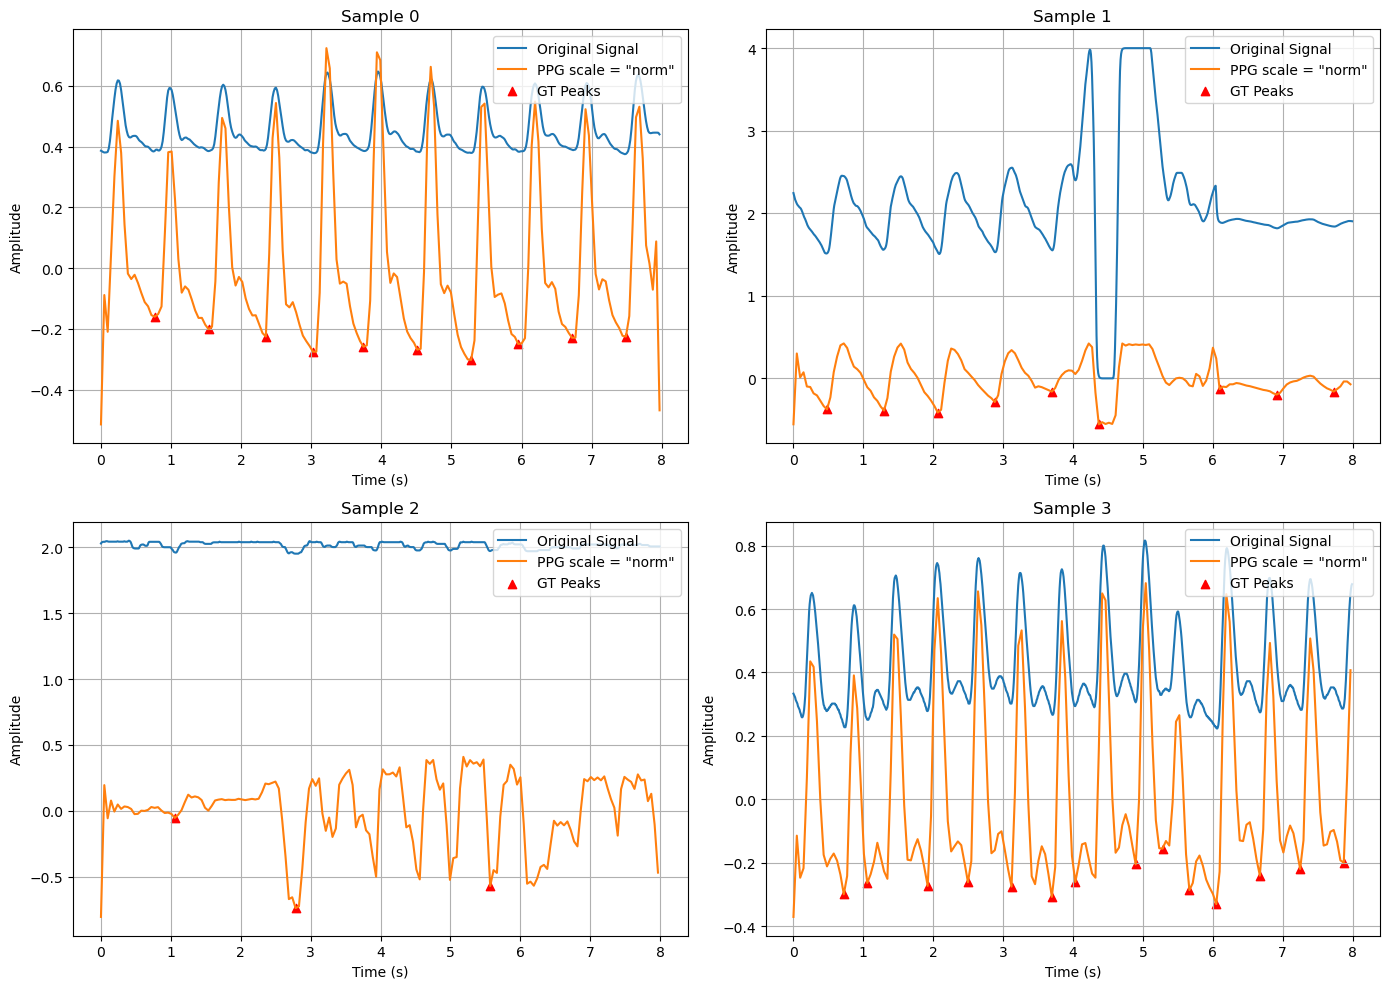

In [15]:
B, _, L = x.shape

# How many to plot
n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), squeeze=False)

for i in range(n_plot):
    ax = axes[i//cols][i%cols]
    x1, y1,original_signal,_,raw_fs = next(iter(train_loader))
    x1 =x1[0][0]
    y1 = y1[0]
    original_signal = original_signal[0][0]
    peaks = np.nonzero(y1 > 0)

    t = np.arange(len(x1)) / FS
    tr = np.arange(len(original_signal)) / (raw_fs[0])

    ax.plot(tr,original_signal,label='Original Signal')
    ax.plot(t, x1, label=f'PPG scale = "norm"')
    ax.scatter(t[peaks], x1[peaks], c='r', marker='^', label='GT Peaks')
    ax.set_title(f'Sample {i}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()
plt.show()

In [16]:
class EarlyStoppingBasic:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [ ]:
# 1) Gather all labels from your training set (flattened)
counts = torch.zeros(2, dtype=torch.long)
for _, yb, _, _,_ in train_loader:
    flat = yb.view(-1).long()                     # ensure integer dtype
    c = torch.bincount(flat, minlength=2)         # c[0]=#zeros, c[1]=#ones
    counts += c
neg, pos = counts[0].item(), counts[1].item()



alpha = 0.5
imbalance_ratio = neg / pos
pos_weight = imbalance_ratio**alpha   # ≃ 5.0
print(f"neg={neg}, pos={pos}")
print(f"Imbalance ratio (neg/pos): {imbalance_ratio:.2f}")
print(f"pos_weight imbalance_ratio*alpha [{alpha}]: {pos_weight:.2f}")
# 3) Build your pos_weight from that ratio
pos_weight = torch.tensor([pos_weight], dtype=torch.float32, device=device)

# 4) Create your loss once, using that pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

scaler = torch.amp.GradScaler(enabled=False)       # autocast handles bfloat16

model = UNet1D()
print(summary(model, input_size=(1,1, WIN_LEN)))

model = model.to(device)

LEARNING_RATE = 5e-4;
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,'max',       
    patience=3,      
    factor=0.8,   
    threshold_mode='rel'  
)
early_stopper = EarlyStoppingBasic(patience=5, min_delta=1e-4)

print(f'Starting Learning Rate: {LEARNING_RATE}')

neg=6853889, pos=403263
Imbalance ratio (neg/pos): 17.00
pos_weight imbalance_ratio*alpha [0.5]: 4.12
Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 167]                  --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 167]              --
│    │    └─Sequential: 3-1              [1, 16, 167]              2,544
│    └─ConvBlock: 2-2                    [1, 32, 83]               --
│    │    └─Sequential: 3-2              [1, 32, 83]               14,016
│    └─ConvBlock: 2-3                    [1, 64, 41]               --
│    │    └─Sequential: 3-3              [1, 64, 41]               55,680
│    └─ConvBlock: 2-4                    [1, 128, 20]              --
│    │    └─Sequential: 3-4              [1, 128, 20]              221,952
├─ConvBlock: 1-2                         [1, 128, 10]              --
│    └─Sequential: 2-5               

In [18]:
# Reinforcement Learning
baseline = torch.tensor(0., device=device)
MIN_RR = 0.3
MAX_RR = 2

MAX_BPM      = 240
MAX_PEAKS    = int(MAX_BPM/60 * config.WIN_SEC)   # = 120
MAX_INTERVAL = MAX_PEAKS - 1                  # = 119

def compute_reward(actions,positions, fs=config.FS,window_sec=config.WIN_SEC,max_bpm = MAX_BPM,
                   min_rr=MIN_RR, max_rr=MAX_RR,max_interval=MAX_INTERVAL) -> float:

    mask      = actions.to(torch.bool)                                             # (B, L)
    pairs = mask[:,:-1] & mask[:,1:]
    deltas = positions[1:] - positions[:-1]            # (L-1)
    reward_vals = torch.where(deltas<min_rr, -1.0,torch.where(deltas>max_rr, -0.1, 1.0))
    reward_matrix = reward_vals[None] * pairs.float()  # broadcast to (B,L-1)
    raw_r            = reward_matrix.sum(dim=1)                    # (B,)
    clipped          = raw_r.clamp(-max_interval, max_interval)  # (B,)
    rewards          = clipped / max_interval                     # (B,)
    return rewards

# 2) Pretrain then anneal RL term
PRETRAIN_EPOCHS   = 10
RL_ANNEAL_EPOCHS  = 10
RL_BETA_MAX       = 0.2

baseline = torch.tensor(0., device=device)
def get_beta(epoch: int) -> float:
    if epoch <= PRETRAIN_EPOCHS:
        return 0.0
    t = min(epoch - PRETRAIN_EPOCHS, RL_ANNEAL_EPOCHS)
    return RL_BETA_MAX * (t / RL_ANNEAL_EPOCHS)

In [19]:
bSaveCheckPoint = True
# ─── Config ────────────────────────────────────────────────────────────────
MODEL_NUM = "conv1dnet_v1_wShuffle"
CKPT_DIR     = f"../trained_model/checkpoints/{MODEL_NUM}_winlen{WIN_LEN}/"
if not os.path.exists(CKPT_DIR):
    os.mkdir(CKPT_DIR)
CKPT_PATTERN = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_*.pth")
SAVE_EVERY   = 5         # save every N epochs
RESUME       = True       # flip to False if you never want to resume
device       = "mps" if torch.backends.mps.is_available() else "cpu"

# ─── Helper: find latest checkpoint ────────────────────────────────────────
def find_latest_checkpoint(pattern=CKPT_PATTERN):
    files = glob.glob(pattern)
    if not files:
        return None
    # extract epoch number from filename
    epochs = [(int(re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f).group(1)), f)
              for f in files if re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f)]
    if not epochs:
        return None
    return max(epochs, key=lambda x: x[0])  # (epoch, filepath)

# ─── On startup: optionally resume ─────────────────────────────────────────
start_epoch = 1
if RESUME:
    latest = find_latest_checkpoint()
    if latest is not None:
        start_epoch, path = latest
        print(f"Resuming from checkpoint epoch {start_epoch}: {path}")
        ckpt = torch.load(path, map_location=device)
        print(ckpt)
        model.load_state_dict(ckpt["model"])
        optim.load_state_dict(ckpt["optim"])
        scheduler.load_state_dict(ckpt["scheduler"])
        baseline = ckpt.get("baseline", baseline)
        ckpt.get("bas")
        # if you saved RNG:
        # torch.random.set_rng_state(ckpt["rng"])
        start_epoch += 1  # next epoch to run
start_epoch

1

Train 	| Epoch 1/200: 100%|██████████| 1358/1358 [03:24<00:00,  6.63it/s]
Val 	| Epoch 1/200: 100%|██████████| 340/340 [00:22<00:00, 15.23it/s]


Best F1 = 73.58% at threshold = 0.65
Epoch 01 | F1 Validaiton: 45.06 | train = 0.2660  | val = 0.1640 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=5.0e-04


Train 	| Epoch 2/200: 100%|██████████| 1358/1358 [03:23<00:00,  6.67it/s]
Val 	| Epoch 2/200: 100%|██████████| 340/340 [00:21<00:00, 15.91it/s]


Best F1 = 80.77% at threshold = 0.66
Epoch 02 | F1 Validaiton: 64.87 | train = 0.1293  | val = 0.1185 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=5.0e-04


Train 	| Epoch 3/200: 100%|██████████| 1358/1358 [03:29<00:00,  6.49it/s]
Val 	| Epoch 3/200: 100%|██████████| 340/340 [00:21<00:00, 15.70it/s]


Best F1 = 85.65% at threshold = 0.69
Epoch 03 | F1 Validaiton: 79.25 | train = 0.0971  | val = 0.0893 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=5.0e-04


Train 	| Epoch 4/200: 100%|██████████| 1358/1358 [03:25<00:00,  6.62it/s]
Val 	| Epoch 4/200: 100%|██████████| 340/340 [00:21<00:00, 15.63it/s]


Best F1 = 87.24% at threshold = 0.69
Epoch 04 | F1 Validaiton: 82.04 | train = 0.0811  | val = 0.0766 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=5.0e-04


Train 	| Epoch 5/200: 100%|██████████| 1358/1358 [03:23<00:00,  6.67it/s]
Val 	| Epoch 5/200: 100%|██████████| 340/340 [00:21<00:00, 15.51it/s]


Best F1 = 88.31% at threshold = 0.66
Epoch 05 | F1 Validaiton: 83.34 | train = 0.0708  | val = 0.0691 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=2.5e-04
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_v1_wShuffle_winlen167/ckpt_epoch_conv1dnet_v1_wShuffle_5.pth


/var/folders/sj/5fy42mkj53n0d261br7nmzzc0000gn/T/ipykernel_65533/2898358363.py:187: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


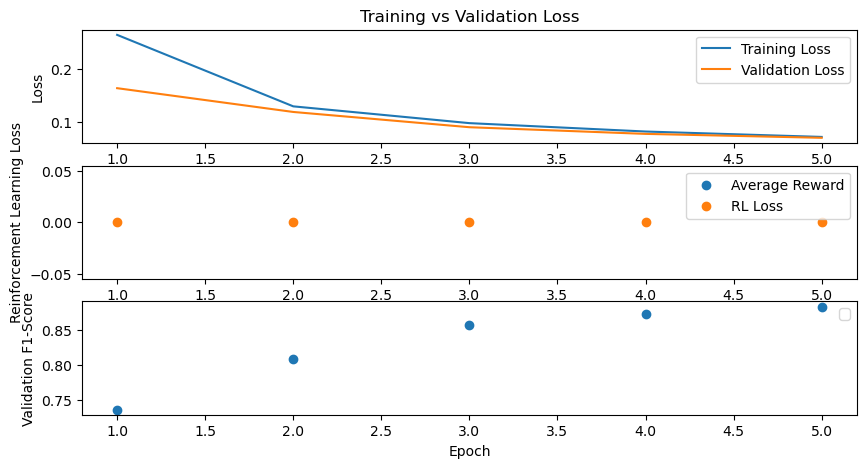

Train 	| Epoch 6/200: 100%|██████████| 1358/1358 [03:29<00:00,  6.50it/s]
Val 	| Epoch 6/200: 100%|██████████| 340/340 [00:23<00:00, 14.28it/s]


Best F1 = 89.85% at threshold = 0.66
Epoch 06 | F1 Validaiton: 85.09 | train = 0.0599  | val = 0.0616 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=2.5e-04


Train 	| Epoch 7/200: 100%|██████████| 1358/1358 [03:29<00:00,  6.48it/s]
Val 	| Epoch 7/200: 100%|██████████| 340/340 [00:22<00:00, 15.35it/s]


Best F1 = 90.15% at threshold = 0.68
Epoch 07 | F1 Validaiton: 86.54 | train = 0.0554  | val = 0.0591 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=2.5e-04


Train 	| Epoch 8/200: 100%|██████████| 1358/1358 [03:29<00:00,  6.48it/s]
Val 	| Epoch 8/200: 100%|██████████| 340/340 [00:23<00:00, 14.69it/s]


Best F1 = 90.06% at threshold = 0.68
Epoch 08 | F1 Validaiton: 87.16 | train = 0.0522  | val = 0.0596 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=2.5e-04


Train 	| Epoch 9/200: 100%|██████████| 1358/1358 [03:35<00:00,  6.30it/s]
Val 	| Epoch 9/200: 100%|██████████| 340/340 [00:22<00:00, 14.89it/s]


Best F1 = 90.33% at threshold = 0.72
Epoch 09 | F1 Validaiton: 88.11 | train = 0.0488  | val = 0.0586 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=1.3e-04


Train 	| Epoch 10/200: 100%|██████████| 1358/1358 [03:26<00:00,  6.56it/s]
Val 	| Epoch 10/200: 100%|██████████| 340/340 [00:23<00:00, 14.65it/s]


Best F1 = 90.94% at threshold = 0.67
Epoch 10 | F1 Validaiton: 88.80 | train = 0.0430  | val = 0.0561 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=1.3e-04
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_v1_wShuffle_winlen167/ckpt_epoch_conv1dnet_v1_wShuffle_10.pth


/var/folders/sj/5fy42mkj53n0d261br7nmzzc0000gn/T/ipykernel_65533/2898358363.py:187: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


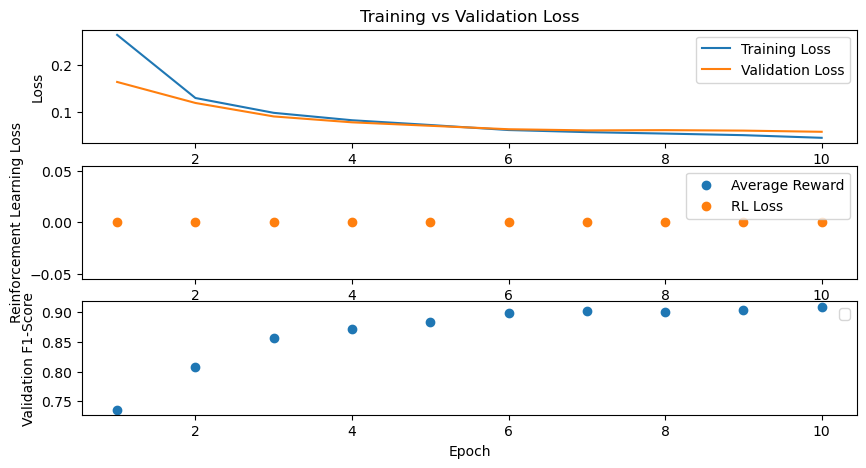

Train 	| Epoch 11/200: 100%|██████████| 1358/1358 [03:33<00:00,  6.37it/s]
Val 	| Epoch 11/200: 100%|██████████| 340/340 [00:21<00:00, 15.54it/s]


Best F1 = 90.99% at threshold = 0.72
Epoch 11 | F1 Validaiton: 89.12 | train = 0.0407  | val = 0.0593 | beta = 0.0200 | rl_loss = 0.0000 | avg_reward=nan  | lr=1.3e-04


Train 	| Epoch 12/200: 100%|██████████| 1358/1358 [03:23<00:00,  6.68it/s]
Val 	| Epoch 12/200: 100%|██████████| 340/340 [00:22<00:00, 15.15it/s]


Best F1 = 91.18% at threshold = 0.72
Epoch 12 | F1 Validaiton: 89.48 | train = 0.0395  | val = 0.0579 | beta = 0.0400 | rl_loss = 0.0000 | avg_reward=nan  | lr=1.3e-04


Train 	| Epoch 13/200: 100%|██████████| 1358/1358 [03:37<00:00,  6.26it/s]
Val 	| Epoch 13/200: 100%|██████████| 340/340 [00:24<00:00, 13.98it/s]


Best F1 = 91.10% at threshold = 0.69
Epoch 13 | F1 Validaiton: 89.07 | train = 0.0382  | val = 0.0639 | beta = 0.0600 | rl_loss = -0.0883 | avg_reward=-0.0266  | lr=6.3e-05


Train 	| Epoch 14/200: 100%|██████████| 1358/1358 [03:34<00:00,  6.33it/s]
Val 	| Epoch 14/200: 100%|██████████| 340/340 [00:22<00:00, 15.45it/s]


Best F1 = 91.35% at threshold = 0.72
Epoch 14 | F1 Validaiton: 89.78 | train = 0.0344  | val = 0.0621 | beta = 0.0800 | rl_loss = 0.0000 | avg_reward=nan  | lr=6.3e-05


Train 	| Epoch 15/200: 100%|██████████| 1358/1358 [03:34<00:00,  6.33it/s]
Val 	| Epoch 15/200: 100%|██████████| 340/340 [00:23<00:00, 14.40it/s]


Best F1 = 91.49% at threshold = 0.76
Epoch 15 | F1 Validaiton: 90.30 | train = 0.0335  | val = 0.0633 | beta = 0.1000 | rl_loss = 0.0000 | avg_reward=nan  | lr=6.3e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_v1_wShuffle_winlen167/ckpt_epoch_conv1dnet_v1_wShuffle_15.pth


/var/folders/sj/5fy42mkj53n0d261br7nmzzc0000gn/T/ipykernel_65533/2898358363.py:187: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


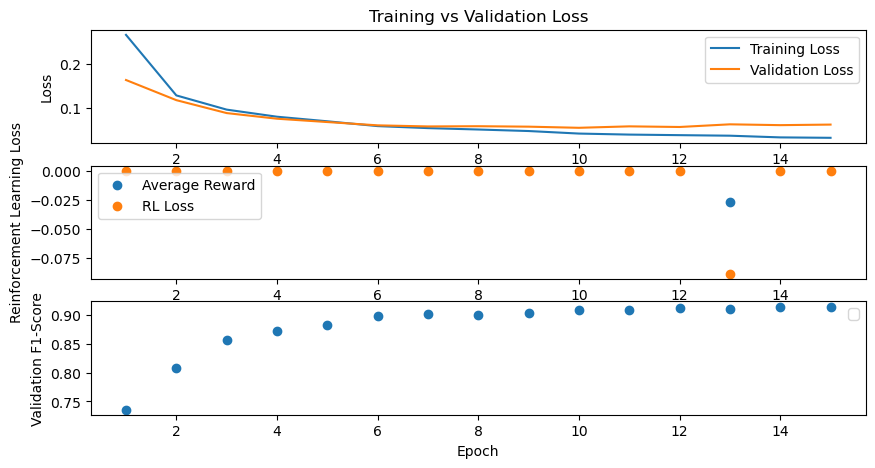

Early stopping triggered at epoch 16


In [ ]:
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter

# in your training script, at top
writer = SummaryWriter(log_dir="runs/exp1")

RL_START_EPOCH      = 10   # don’t do any RL until after epoch 5
RL_CALL_EPOCH_FREQ  = 3    # once you’ve started, run RL only once every 3 epochs

all_train_loss = []
all_val_loss = []
all_rl_loss = []
all_avg_rewards = []


f1_score_vec = []
positions = torch.arange(L, device=device, dtype=torch.float32) / FS
# ----------------------------- training ----------------------------------
# plt.figure()

for epoch in range(start_epoch, EPOCHS+1):
    model.train()
    cumulative_train_loss = 0.0
    cumulative_val_loss = 0.0
    cumulative_rl_loss = 0.0

    total_batches = 0
    epoch_reward = 0.0
    do_rl_epoch = (epoch > RL_START_EPOCH) and ((epoch - RL_START_EPOCH) % RL_CALL_EPOCH_FREQ == 0)
    beta = get_beta(epoch)
    
    for xb, yb,_,_,_ in tqdm(train_loader, desc=f'Train \t| Epoch {epoch}/{EPOCHS}'):
        xb, yb = xb.to(device,non_blocking=True), yb.to(device,non_blocking=True)
        optim.zero_grad(set_to_none=True) 

        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()                 # autocast returns bf16
            sup_loss   = criterion(logits, yb)
            
        rl_loss = torch.tensor(0.0, device=device)

        if  do_rl_epoch and beta > 0.0:
            # # ----------------------- Reinforcement Learning -----------------------
            probs = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
            dist = torch.distributions.Bernoulli(probs)
            actions = dist.sample()

            rewards = compute_reward(actions,positions, fs=config.FS,window_sec=config.WIN_SEC,max_bpm = MAX_BPM,
                   min_rr=MIN_RR, max_rr=MAX_RR,max_interval=MAX_INTERVAL)
            
            # --- build the RL loss ----------------------------------------
            logps   = dist.log_prob(actions).sum(dim=1)   # (B,)
            adv     = rewards - baseline
            rl_loss = -(logps * adv).mean()

            with torch.no_grad():
                baseline.mul_(0.9).add_(0.1 * rewards.mean())

            total_batches += 1
            epoch_reward += rewards.mean().item()
            cumulative_rl_loss += rl_loss.item() * xb.size(0)
       
        # total loss and backward 
        loss = sup_loss + beta*rl_loss
        if torch.isnan(sup_loss): raise ValueError('NaN in combines loss')

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()

        cumulative_train_loss += sup_loss.item() * xb.size(0)

    mean_rl = cumulative_rl_loss / len(train_loader.dataset)
    mean_train = cumulative_train_loss / (len(train_loader.dataset))
    avg_reward = (epoch_reward / total_batches) if total_batches > 0 else float("nan")
    

    # ───────────────── validation ─────────────────────────────────────
    all_preds = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for xb, yb,_,_,_ in tqdm(val_loader, desc=f'Val \t| Epoch {epoch}/{EPOCHS}'):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.autocast("mps", dtype=torch.bfloat16):
                logits = model(xb).float()
                validation_loss   = criterion(logits, yb)
            if torch.isnan(validation_loss): raise ValueError('NaN loss')
            cumulative_val_loss += validation_loss.item() * xb.size(0)

            # Binarize outputs using sigmoid + threshold
            threshold = 0.5
            probs_cpu = torch.sigmoid(logits).cpu()
            targets_cpu = yb.cpu()
            probs = probs_cpu.numpy().ravel()
            # preds = (probs >= threshold).astype(int)
            targets = targets_cpu.numpy().ravel().astype(int)

            all_preds.append(probs)
            all_targets.append(targets)
    # Flatten everything
    all_preds = np.concatenate(all_preds, axis=None)
    all_targets = np.concatenate(all_targets, axis=None)

    default_preds = (all_preds >= 0.5).astype(int)
    default_f1    = f1_score(all_targets, default_preds)
    writer.add_scalar("F1/val_default", default_f1, epoch)

    best_f1, best_thr = 0.0, 0.5
    for thr in np.linspace(0.1, 0.9, 81):
        preds = (all_preds >= thr).astype(int)
        f1    = f1_score(all_targets, preds)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr

    print(f"Best F1 = {best_f1*100:.2f}% at threshold = {best_thr:.2f}")
    # curr_f1_val = f1_score(all_targets, all_preds)
    mean_val = cumulative_val_loss / (len(val_loader.dataset))

    scheduler.step(mean_val)         

    f1_score_vec.extend([epoch,best_f1])
    all_train_loss.extend([epoch,mean_train])
    all_rl_loss.extend([epoch,mean_rl])
    all_val_loss.extend([epoch,mean_val])
    all_avg_rewards.extend([epoch,avg_reward])

    writer.add_scalar('Loss/train', mean_train, epoch)
    writer.add_scalar('Loss/val',   mean_val,   epoch)
    # writer.add_scalar('F1/val',     curr_f1_val,     epoch)
    writer.add_scalar("F1/val_best", best_f1,    epoch)
    writer.add_scalar("Threshold/val", best_thr, epoch)
    

    stop = early_stopper.step(mean_val)

    print(f"Epoch {epoch:02d} | "
          f"F1 Validaiton: {f1*100:.2f} | "
          f"train = {mean_train:.4f}  | "
          f"val = {mean_val:.4f} | "
          f"beta = {beta:.4f} | "
          f"rl_loss = {mean_rl:.4f} | "
          f"avg_reward={avg_reward:.4f}  | "
          f"lr={optim.param_groups[0]['lr']:.1e}")

    # # ─── Save checkpoint every N epochs ──────────────────────────────────
    if (epoch % SAVE_EVERY == 0) and (bSaveCheckPoint):
        # plt.close()
        os.makedirs(CKPT_DIR, exist_ok=True)
        ckpt_path = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_{epoch}.pth")
        torch.save({
            "epoch":     epoch,
            "model":     model.state_dict(),
            "optim":     optim.state_dict(),
            "scheduler": scheduler.state_dict(),
            "baseline":  baseline,
            # "rng":       torch.random.get_rng_state(),
            "all_train_loss":all_train_loss,
            "all_val_loss":all_val_loss,
            "all_rl_loss":all_rl_loss,
            "f1_score_vec":f1_score_vec,
            "all_avg_rewards": all_avg_rewards

        }, ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")
        # plt.figure(figsize=(10, 5))
        # ax1 = plt.subplot(311)
        # plt.plot(all_train_loss[0::2], all_train_loss[1::2], label='Training Loss')
        # plt.plot(all_val_loss[0::2], all_val_loss[1::2], label='Validation Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title('Training vs Validation Loss')
        # plt.legend()

        # plt.subplot(312, sharex=ax1)
        # plt.scatter(all_avg_rewards[0::2], all_avg_rewards[1::2], label='Average Reward')
        # plt.scatter(all_rl_loss[0::2], all_rl_loss[1::2], label='RL Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Reinforcement Learning Loss')
        # plt.legend()

        # plt.subplot(313)
        # plt.scatter(f1_score_vec[0::2],f1_score_vec[1::2])
        # plt.xlabel('Epoch')
        # plt.ylabel('Validation F1-Score')

        # plt.legend()
        # plt.show()

    if stop:
        print("Early stopping triggered at epoch", epoch+1)
        break
    # after your epoch loop:
    writer.flush()
    writer.close()
    torch.mps.empty_cache() 



In [21]:
len(all_targets)

1814121

/var/folders/sj/5fy42mkj53n0d261br7nmzzc0000gn/T/ipykernel_65533/1045695910.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


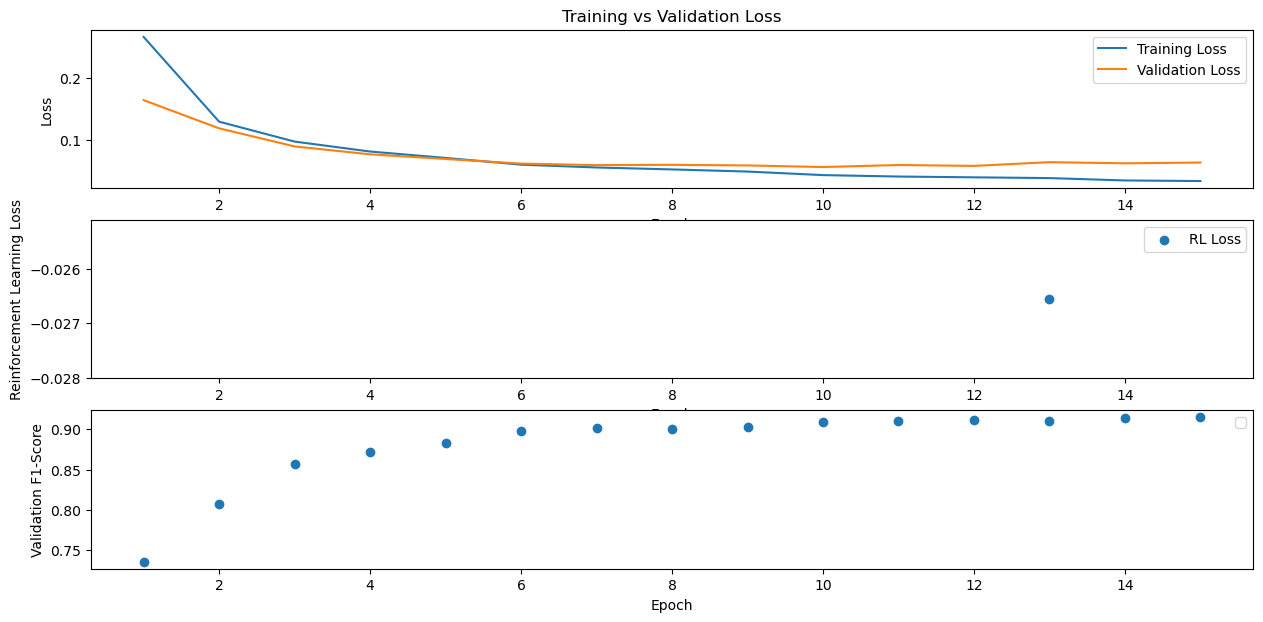

In [27]:

plt.figure(figsize=(15, 7))
ax1 = plt.subplot(311)
plt.plot(all_train_loss[0::2], all_train_loss[1::2], label='Training Loss')
plt.plot(all_val_loss[0::2], all_val_loss[1::2], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(312, sharex=ax1)
plt.scatter(all_avg_rewards[0::2], all_avg_rewards[1::2], label='RL Loss')
plt.xlabel('Epoch')
plt.ylabel('Reinforcement Learning Loss')
plt.legend()

plt.subplot(313)
plt.scatter(f1_score_vec[0::2],f1_score_vec[1::2])
plt.xlabel('Epoch')
plt.ylabel('Validation F1-Score')

plt.legend()
plt.show()

In [28]:
import datetime

tz = datetime.timezone.utc
ft = "%Y_%m_%d_%H_%M_%S_%z"
t = datetime.datetime.now(tz=tz).strftime(ft)
# print(t)

CKPT_FILE_NAME = f'PPG_PEAK_DETECTION_MODEL_{epoch}_{t}.pth'
CKPT_FILE = os.path.join('../trained_model',CKPT_FILE_NAME)
print(CKPT_FILE)
# save weights
torch.save(model.state_dict(), CKPT_FILE)
print('Checkpoint saved.')


../trained_model/PPG_PEAK_DETECTION_MODEL_15_2025_05_03_18_30_16_+0000.pth
Checkpoint saved.


In [29]:
FOLDER_PATH = 'length_full'
TEST_PATH = os.path.join('../data','development_dataset',FOLDER_PATH,'test_dataset.h5')  # update if your file lives elsewhere

CKPT = ckpt_path
# if not os.path.exists(TEST_LOADER_PATH):
test_ds = PPGWindow(TEST_PATH)
torch.save(test_ds,TEST_LOADER_PATH)
# else:
    # test_ds = torch.load(TEST_LOADER_PATH,weights_only=False)

test_loader = DataLoader(test_ds, batch_size=config.BATCH, shuffle=True, num_workers=0, pin_memory=False,collate_fn=custom_collate)

# ------------ load the trained model -------------------------------------
model  = UNet1D().to(device)
ckpt = torch.load(CKPT, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()



UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Co

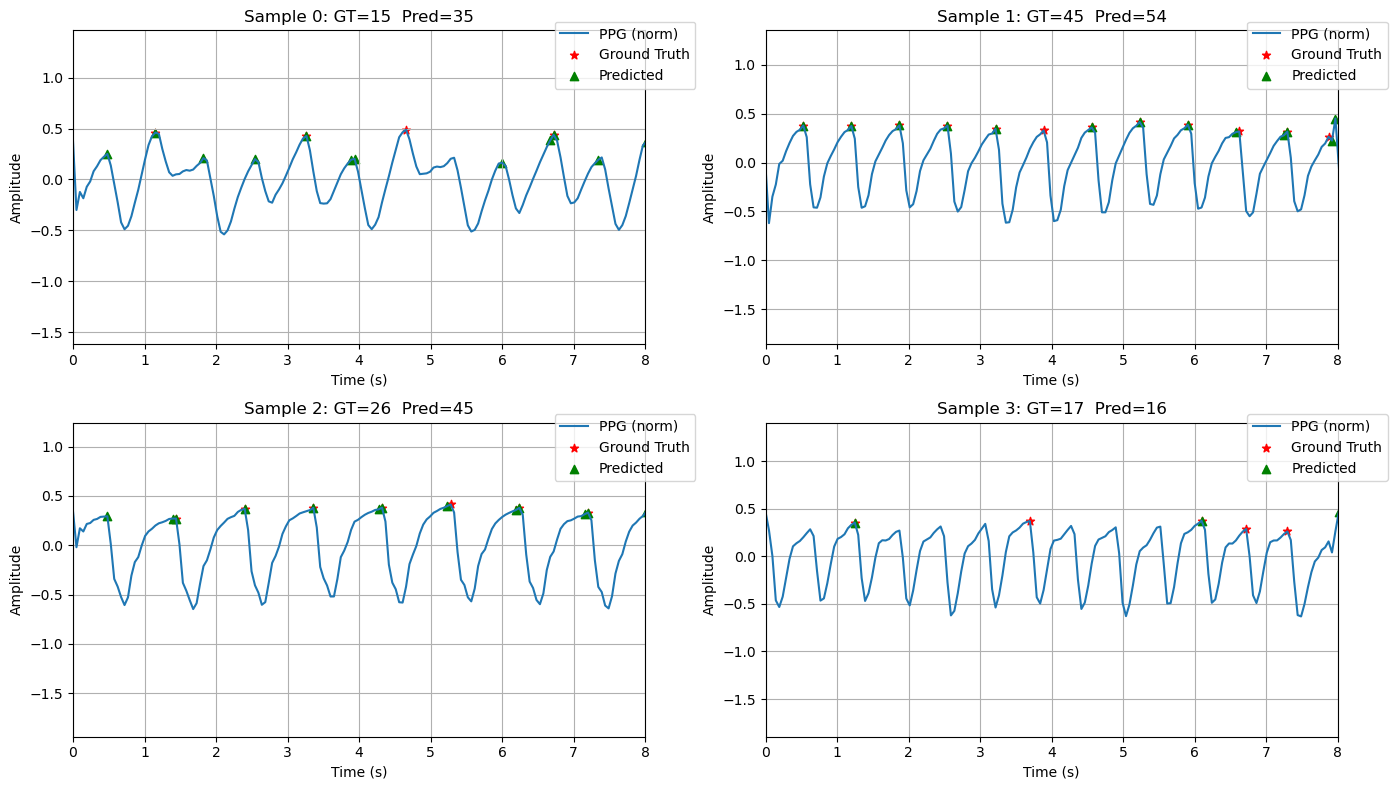

In [31]:
THRESH   = 0.7        # probability cut‑off for “peak”
xb, yb, orig,_,_ = next(iter(test_loader))     # xb: (B,1,L), yb: (B,L), orig:(B,1,L)
xb, yb, orig = xb.to(device), yb.to(device), orig  # orig can stay on CPU

yb_cpu = yb.cpu().numpy()          # shape (B, L)

B, _, L = xb.shape
t = np.arange(L) / FS 

n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)


for i in range(n_plot):
    ax = axes[i//cols][i%cols]
    original_window = orig[i][0].numpy()   # shape (L,)
    original_window = -original_window

    window_norm = xb[i,0].cpu().numpy()   # shape (L,)
    window_norm = -window_norm

    inp  = xb[i:i+1].to(device)            # shape (1,1,L)
    with torch.no_grad():
        logits = (model(inp))
        prob = torch.sigmoid(logits)[0]  # shape (L,)
        prob_np    = prob.cpu().numpy()
    peaks_pred = np.where(prob_np > THRESH)[0]

    # 4) ground‑truth peaks from yb
    gt_peaks = np.where(yb_cpu[i] > 0)[0]
    # 5) now plot
    ax.plot(t, window_norm,label='PPG (norm)', linestyle='-')
    ax.scatter(t[gt_peaks], window_norm[gt_peaks],
               c='r', marker='*', label='Ground Truth')
    ax.scatter(t[peaks_pred], window_norm[peaks_pred],
               c='g', marker='^', label='Predicted')


    ax.set_title(f"Sample {i}: GT={len(gt_peaks)}  Pred={len(peaks_pred)}")
    ax.set_xlim(0, WIN_SEC)
    ax.set_ylim(np.min(window_norm)*3, np.max(window_norm)*3)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1.05))
    ax.grid()


    # ax1.hist(np.diff(t[peaks_pred]))

plt.tight_layout()
plt.show()

In [32]:

print('Ground Truth Peak Positions: \t', gt_peaks)
print('Predicted Peaks Positions: \t', peaks_pred)
print(len(gt_peaks[1:] - gt_peaks[:-1]))
print(len(peaks_pred[1:] - peaks_pred[:-1]))


Ground Truth Peak Positions: 	 [ 26  77 127 140 152 193 244 294 307 319 360 411 461 474 486 527 578]
Predicted Peaks Positions: 	 [ 26 127 167 193 244 293 294 334 335 360 361 411 461 578 603 616]
16
15


In [35]:
for i in range(0,1):
    model.eval()
    all_test_loss = [];
    cumulative_test_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb,_,_,_ in tqdm(test_loader, desc=f'Test\t'):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.autocast("mps", dtype=torch.bfloat16):
                logits = model(xb)
                test_loss   = criterion(logits, yb)
            if torch.isnan(test_loss): raise ValueError('NaN loss')
            cumulative_test_loss += test_loss.item() * xb.size(0)
            
            # Binarize outputs using sigmoid + threshold
            probs = torch.sigmoid(logits)
            preds = (probs > 0.7).long().cpu().numpy()     # shape (B, win_len)
            targets = yb.cpu().numpy()              # shape (B, win_len)

        all_preds.append(preds)
        all_targets.append(targets)

    # Flatten everything
    all_preds = np.concatenate(all_preds, axis=None)
    all_targets = np.concatenate(all_targets, axis=None)

    f1 = f1_score(all_targets, all_preds)

    mean_val = cumulative_test_loss / (len(test_loader.dataset))
    all_test_loss.append(mean_val)

    print(f'F1 Test Score: {f1*100:.2f} | Test Loss: {mean_val:.4f}')

Test	: 100%|██████████| 425/425 [00:26<00:00, 15.81it/s]

F1 Test Score: 70.97 | Test Loss: 0.3957
